In [87]:
!pip install -U albumentations

In [88]:
%matplotlib inline

In [89]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import numpy as np
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR,OneCycleLR
import torch.optim as optim
from tqdm import tqdm


Training a Classifier
=====================

This is it. You have seen how to define neural networks, compute loss and make
updates to the weights of the network.

Now you might be thinking,

What about data?
----------------

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.*Tensor``.

-  For images, packages such as Pillow, OpenCV are useful
-  For audio, packages such as scipy and librosa
-  For text, either raw Python or Cython based loading, or NLTK and
   SpaCy are useful

Specifically for vision, we have created a package called
``torchvision``, that has data loaders for common datasets such as
Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

.. figure:: /_static/img/cifar10.png
   :alt: cifar10

   cifar10


Training an image classifier
----------------------------

We will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolution Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

1. Loading and normalizing CIFAR10
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Using ``torchvision``, it’s extremely easy to load CIFAR10.



In [90]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
import albumentations as A
from torch.utils.data import DataLoader, Dataset
from PIL import Image

In [91]:
import matplotlib.pyplot as plt
import numpy as np
!pip install torchsummary
from torchsummary import summary

### Augmentation

In [92]:
# EXPERIMENT horizontalflip_prob increased to 0.3 from 0.2
def data_albumentations(horizontalflip_prob = 0.3,
                        rotate_limit = 15,
                        shiftscalerotate_prob = 0.25,
                        num_holes = 1,
                        cutout_prob = 0.5):
    # Calculate mean and std deviation for cifar dataset
    mean,std = calculate_mean_std()
    
    # Train Phase transformations
    train_transforms = A.Compose([A.HorizontalFlip(p=horizontalflip_prob),
                                  A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=rotate_limit, p=shiftscalerotate_prob),
                                  A.CoarseDropout(max_holes=num_holes,min_holes = 1, max_height=16, max_width=16, 
                                  p=cutout_prob,fill_value=tuple([x * 255.0 for x in mean]),
                                  min_height=16, min_width=16),
                                  A.ColorJitter(p=0.25,brightness=0.3, contrast=0.3, saturation=0.30, hue=0.2),
                                  A.ToGray(p=0.15),
                                  A.Normalize(mean=mean, std=std,always_apply=True),
                                  ToTensorV2()
                                ])

    # Test Phase transformations
    test_transforms = A.Compose([A.Normalize(mean=mean, std=std, always_apply=True),
                                 ToTensorV2()])

    return lambda img:train_transforms(image=np.array(img))["image"],lambda img:test_transforms(image=np.array(img))["image"]

### Helper functions

In [93]:
def calculate_mean_std():
  train_transform = transforms.Compose([transforms.ToTensor()])
  train_set = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
  mean = train_set.data.mean(axis=(0,1,2))/255
  std = train_set.data.std(axis=(0,1,2))/255
  return mean, std

In [94]:
def set_seed(seed,cuda_available):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda_available:
        torch.cuda.manual_seed(seed)

In [95]:
def model_summary(model, input_size=(3, 32, 32)):
  use_cuda = torch.cuda.is_available()
  device = torch.device("cuda" if use_cuda else "cpu")
  print(model)
  summary(model,input_size)

In [96]:
def class_level_accuracy(model, test_loader, device, 
                         class_correct = list(0. for i in range(10)),
                         class_total = list(0. for i in range(10))):
  # specify the image classes
  classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
             'dog', 'frog', 'horse', 'ship', 'truck']
  with torch.no_grad():
    for data in test_loader:
      images, labels = data
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      _, predicted = torch.max(outputs, 1)
      c = (predicted == labels).squeeze()
      for i in range(4):
        label = labels[i]
        class_correct[label] += c[i].item()
        class_total[label] += 1
  for i in range(10):
    print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

In [97]:
def wrong_predictions(test_loader,
                      use_cuda,
                      model):
        class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
        
        wrong_images=[]
        wrong_label=[]
        correct_label=[]
        with torch.no_grad():
            for data, target in test_loader:
                if use_cuda:
                  data = data.cuda()
                  target = target.cuda()

                output = model(data)        
                pred = output.argmax(dim=1, keepdim=True).squeeze()  # get the index of the max log-probability
                wrong_pred = (pred.eq(target.view_as(pred)) == False)
                wrong_images.append(data[wrong_pred])
                wrong_label.append(pred[wrong_pred])
                correct_label.append(target.view_as(pred)[wrong_pred])  
      
                wrong_predictions = list(zip(torch.cat(wrong_images),torch.cat(wrong_label),torch.cat(correct_label)))    
            print(f'Total wrong predictions are {len(wrong_predictions)}')
      
      
            fig = plt.figure(figsize=(18,20))
            fig.tight_layout()
            # mean,std = helper.calculate_mean_std("CIFAR10")
            for i, (img, pred, correct) in enumerate(wrong_predictions[:10]):
                  img, pred, target = img.cpu().numpy(), pred.cpu(), correct.cpu()
        
                  #mean = torch.FloatTensor(mean).view( 3, 1, 1).expand_as(img).cpu()
                  #std = torch.FloatTensor(std).view( 3, 1, 1).expand_as(img).cpu()
                  #img = img.mul(std).add(mean)
                  #img=img.numpy()
                  
                  img = np.transpose(img, (1, 2, 0)) / 2 + 0.5
                  ax = fig.add_subplot(5, 5, i+1)
                  ax.axis('off')
                  ax.set_title(f'\nactual : {class_names[target.item()]}\npredicted : {class_names[pred.item()]}',fontsize=10)  
                  ax.imshow(img)  
          
            plt.show()

In [98]:
def train(model, device, train_loader, optimizer, epoch,train_acc,train_loss,lambda_l1,scheduler,criterion,lrs,grad_clip=None):

  model.train()
  pbar = tqdm(train_loader)
  
  correct = 0
  processed = 0
  
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = criterion(y_pred, target)
    
    #L1 Regularization
    if lambda_l1 > 0:
      l1 = 0
      for p in model.parameters():
        l1 = l1 + p.abs().sum()
      loss = loss + lambda_l1*l1

    train_loss.append(loss.data.cpu().numpy().item())

    # Backpropagation
    loss.backward()
    
    # Gradient clipping
    if grad_clip: 
        nn.utils.clip_grad_value_(model.parameters(), grad_clip)
        
    optimizer.step()
    scheduler.step()
    lrs.append(get_lr(optimizer))

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} LR={lrs[-1]:0.5f} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

In [99]:
# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

In [100]:
def visualize_sample_test_result(model,test_loader,use_cuda):
  # obtain one batch of test images
  dataiter = iter(test_loader)
  images, labels = dataiter.next()
  images.numpy()
  class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

  # move model inputs to cuda, if GPU available
  if use_cuda:
    images = images.cuda()

  # get sample outputs
  output = model(images)
  # convert output probabilities to predicted class
  _, preds_tensor = torch.max(output, 1)
  preds = np.squeeze(preds_tensor.numpy()) if not use_cuda else np.squeeze(preds_tensor.cpu().numpy())
 # plot the images in the batch, along with predicted and true labels
  fig = plt.figure(figsize=(25, 4))
  for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx].cpu())
    ax.set_title("{} ({})".format(class_names[preds[idx]], class_names[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))   

## Data Loader

In [101]:
class Cifar10DataLoader:
    def __init__(self,batchsize=256):
      self.batch_size = batchsize
      self.num_workers = 2
      self.pin_memory = True

      train_transforms, test_transforms = data_albumentations()

      trainset = datasets.CIFAR10(root='./data', train=True,
                                  download=True, transform=train_transforms)
      
      testset  = datasets.CIFAR10(root='./data', train=False,
                                  download=True, transform=test_transforms)
      
      self.train_loader = torch.utils.data.DataLoader(trainset,
                                                      batch_size = self.batch_size,
                                                      shuffle = True,
                                                      num_workers = self.num_workers,
                                                      pin_memory = self.pin_memory)
      
      self.test_loader = torch.utils.data.DataLoader(testset, 
                                                      batch_size = self.batch_size,
                                                      shuffle = True,
                                                      num_workers = self.num_workers,
                                                      pin_memory = self.pin_memory)

## Training Functions

In [102]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [103]:
def train(model, device, train_loader, optimizer, epoch,train_acc,train_loss,lambda_l1,scheduler,criterion,lrs,grad_clip=None):

  model.train()
  pbar = tqdm(train_loader)
  
  correct = 0
  processed = 0
  
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = criterion(y_pred, target)
    
    #L1 Regularization
    if lambda_l1 > 0:
      l1 = 0
      for p in model.parameters():
        l1 = l1 + p.abs().sum()
      loss = loss + lambda_l1*l1

    train_loss.append(loss.data.cpu().numpy().item())

    # Backpropagation
    loss.backward()
    
    # Gradient clipping
    if grad_clip: 
        nn.utils.clip_grad_value_(model.parameters(), grad_clip)
        
    optimizer.step()
    scheduler.step()
    lrs.append(get_lr(optimizer))

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} LR={lrs[-1]:0.5f} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

In [104]:
def test(model, device, test_loader,test_acc,test_losses,criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [105]:
import torch.nn as nn
import torch.nn.functional as F


import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self,dropout):
        super(Net, self).__init__()
        
        ## Convolution Block1
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1, bias = False),  # Input: 32x32x3 | Output: 32x32x32 | RF: 3x3
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout2d(dropout),

            nn.Conv2d(32, 64, 3, padding=1, bias = False), # Input: 32x32x32 | Output: 32x32x64 | RF: 5x5
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout2d(dropout)
        )
        
        ## Transition Block1
        self.trans1 = nn.Sequential(
            nn.Conv2d(64, 32,1, stride=2), # Input: 32x32x64 | Output: 16x16x32 | RF: 5x5
            nn.ReLU(),
        )

        ## Convolution Block2
        self.conv2 =  nn.Sequential(
            nn.Conv2d(32, 32, 3,  padding=1, bias = False), # Input: 16x16x32 | Output: 16x16x32 | RF: 9x9
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout2d(dropout),

            ## Depthwise Seperable Convolution1
            nn.Conv2d(32,32, 3,  padding=1,groups=32 ,bias = False),  # Input: 16x16x32 | Output: 16x16x32 | RF: 13x13
            nn.Conv2d(32, 64, 1, padding=1, bias = False),   # Input: 16x16x32 | Output: 18x18x64 | RF: 13x13
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout2d(dropout),
        )
        
        #Transition Block2
        self.trans2 = nn.Sequential(

            nn.Conv2d(64, 32, 1, stride=2), # Input: 18x18x32 | Output: 9x9x64 | RF: 13x13
            nn.ReLU()
        )

        #Convolution Block3
        self.conv3 = nn.Sequential(
            
            ## Dilation Block
            nn.Conv2d(32, 64, 3,  padding=1, bias = False,dilation=2), # Input: 9x9x64 | Output: 7x7x64 | RF: 29x29
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout2d(dropout),

            nn.Conv2d(64, 64, 3,  padding=1, bias = False),  # Input: 7x7x64| Output: 7x7x64 | RF: 45x45
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout2d(dropout),
        )

        #Transition Block3
        self.trans3 = nn.Sequential(

            nn.Conv2d(64, 16, 1, stride=2), # Input: 7x7x64| Output: 4x4x16 | RF: 61x61
            nn.ReLU()
        )

        #Convolution Block4        
        self.conv4 = nn.Sequential(
            nn.Conv2d(16, 32, 3, padding=1, bias = False), # Input: 4x4x16 | Output: 4x4x32 | RF: 93x93
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout2d(dropout),

            ## Depthwise seperable Convolution2
            nn.Conv2d(32,32, 3,  padding=1,groups=32 ,bias = False),# Input: 4x4x16 | Output: 4x4x32 | RF: 125x125
            nn.Conv2d(32, 10, 1, padding=1, bias = False),          # Input: 4x4x32| Output: 6x6x10 | RF: 125x125
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout2d(dropout),
        )

        ## Output Block
        self.gap = nn.Sequential(
            nn.AdaptiveAvgPool2d(1)
        ) 


    def forward(self, x):
        x = self.conv1(x)
        x = self.trans1(x)

        x = self.conv2(x) 
        x = self.trans2(x) 

        x = self.conv3(x) 
        x = self.trans3(x)

        x = self.conv4(x)
        x = self.gap(x)

        x = x.view(-1,10)
        return F.log_softmax(x,dim=1)

## Run Experiments

In [106]:
def run_experiments(device,
                    dataset,
                    epochs,
                    model):
  l1_factor = 0
  l2_factor = 0.0001
  # optim_type = optim.Adam
  criterion = nn.CrossEntropyLoss()
  # opt_func = optim.Adam
  lr = 0.01
  grad_clip = 0.1
  train_losses = []
  test_losses = []
  train_accuracy = []
  test_accuracy = []
  lrs=[]

  model = model
  optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=l2_factor)
  scheduler = OneCycleLR(optimizer, max_lr=lr,epochs=epochs,steps_per_epoch=len(dataset.train_loader))

  for epoch in range(1, epochs + 1):
    print(f'Epoch {epoch}:')
    train(model, device, dataset.train_loader, optimizer,epoch, train_accuracy, train_losses, l1_factor,scheduler,criterion,lrs,grad_clip)
    test(model, device, dataset.test_loader,test_accuracy,test_losses,criterion)
  
  return (train_accuracy,train_losses,test_accuracy,test_losses),model


In [107]:
def save_experiment(self,model, experiment_name='cifar10-adv'):
  print(f"Saving the model for {experiment_name}")
  torch.save(model, './saved_models/{}.pt'.format(experiment_name))

## Training

In [108]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [109]:
cifar_dataset=Cifar10DataLoader()

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


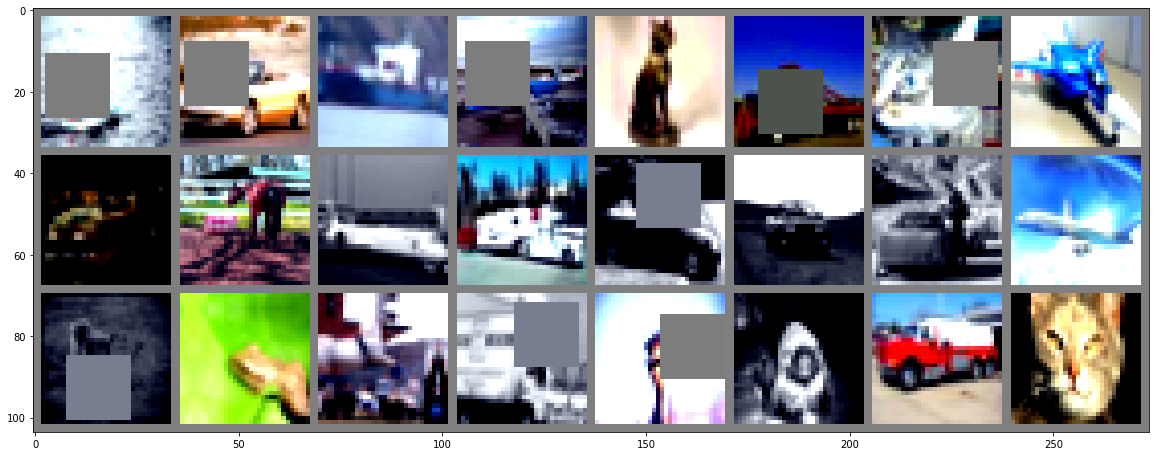

In [110]:
fig, ax = plt.subplots(figsize=(20, 20))
# get some random training images
dataiter = iter(cifar_dataset.train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[:24]))

In [111]:
experiment_name = "cifar10-training"
epochs = 65
dropout = 0.05 ## increased from .01 - EXPERIMENT
model = Net(dropout).to(device)

In [112]:
model_summary(model)

Net(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout2d(p=0.05, inplace=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (5): ReLU()
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout2d(p=0.05, inplace=False)
  )
  (trans1): Sequential(
    (0): Conv2d(64, 32, kernel_size=(1, 1), stride=(2, 2))
    (1): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout2d(p=0.05, inplace=False)
    (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
    (5): Conv2d(32, 64, kernel_size=(1, 1),

In [113]:
exp_metrics={}

exp_metrics[experiment_name],model = run_experiments(device,
                                                       cifar_dataset,
                                                       epochs,
                                                       model)

save_experiment(model,experiment_name)

Epoch 1:


Loss=1.842714548110962 Batch_id=195 LR=0.00046 Accuracy=25.46: 100%|██████████| 196/196 [00:26<00:00,  7.36it/s]



Test set: Average loss: 0.0069, Accuracy: 4192/10000 (41.92%)

Epoch 2:


Loss=1.7410739660263062 Batch_id=195 LR=0.00065 Accuracy=38.34: 100%|██████████| 196/196 [00:26<00:00,  7.49it/s]



Test set: Average loss: 0.0059, Accuracy: 5216/10000 (52.16%)

Epoch 3:


Loss=1.5756123065948486 Batch_id=195 LR=0.00095 Accuracy=45.11: 100%|██████████| 196/196 [00:26<00:00,  7.51it/s]



Test set: Average loss: 0.0054, Accuracy: 5637/10000 (56.37%)

Epoch 4:


Loss=1.43137526512146 Batch_id=195 LR=0.00136 Accuracy=49.46: 100%|██████████| 196/196 [00:26<00:00,  7.51it/s]



Test set: Average loss: 0.0051, Accuracy: 5839/10000 (58.39%)

Epoch 5:


Loss=1.4098169803619385 Batch_id=195 LR=0.00188 Accuracy=53.00: 100%|██████████| 196/196 [00:26<00:00,  7.51it/s]



Test set: Average loss: 0.0045, Accuracy: 6379/10000 (63.79%)

Epoch 6:


Loss=1.2800651788711548 Batch_id=195 LR=0.00247 Accuracy=56.02: 100%|██████████| 196/196 [00:26<00:00,  7.54it/s]



Test set: Average loss: 0.0039, Accuracy: 6731/10000 (67.31%)

Epoch 7:


Loss=1.444833517074585 Batch_id=195 LR=0.00314 Accuracy=58.05: 100%|██████████| 196/196 [00:25<00:00,  7.56it/s]



Test set: Average loss: 0.0037, Accuracy: 6935/10000 (69.35%)

Epoch 8:


Loss=1.1026893854141235 Batch_id=195 LR=0.00387 Accuracy=59.73: 100%|██████████| 196/196 [00:26<00:00,  7.53it/s]



Test set: Average loss: 0.0037, Accuracy: 6911/10000 (69.11%)

Epoch 9:


Loss=1.1838058233261108 Batch_id=195 LR=0.00462 Accuracy=60.51: 100%|██████████| 196/196 [00:25<00:00,  7.62it/s]



Test set: Average loss: 0.0035, Accuracy: 6998/10000 (69.98%)

Epoch 10:


Loss=1.2495582103729248 Batch_id=195 LR=0.00540 Accuracy=61.13: 100%|██████████| 196/196 [00:25<00:00,  7.54it/s]



Test set: Average loss: 0.0034, Accuracy: 7056/10000 (70.56%)

Epoch 11:


Loss=1.1495780944824219 Batch_id=195 LR=0.00616 Accuracy=62.32: 100%|██████████| 196/196 [00:25<00:00,  7.54it/s]



Test set: Average loss: 0.0033, Accuracy: 7229/10000 (72.29%)

Epoch 12:


Loss=0.9609891772270203 Batch_id=195 LR=0.00690 Accuracy=62.79: 100%|██████████| 196/196 [00:26<00:00,  7.53it/s]



Test set: Average loss: 0.0031, Accuracy: 7427/10000 (74.27%)

Epoch 13:


Loss=1.1333078145980835 Batch_id=195 LR=0.00760 Accuracy=63.13: 100%|██████████| 196/196 [00:25<00:00,  7.54it/s]



Test set: Average loss: 0.0033, Accuracy: 7224/10000 (72.24%)

Epoch 14:


Loss=1.1612625122070312 Batch_id=195 LR=0.00824 Accuracy=63.87: 100%|██████████| 196/196 [00:25<00:00,  7.55it/s]



Test set: Average loss: 0.0030, Accuracy: 7416/10000 (74.16%)

Epoch 15:


Loss=1.0347710847854614 Batch_id=195 LR=0.00879 Accuracy=64.49: 100%|██████████| 196/196 [00:26<00:00,  7.53it/s]



Test set: Average loss: 0.0033, Accuracy: 7209/10000 (72.09%)

Epoch 16:


Loss=1.051486849784851 Batch_id=195 LR=0.00926 Accuracy=64.81: 100%|██████████| 196/196 [00:25<00:00,  7.59it/s]



Test set: Average loss: 0.0031, Accuracy: 7334/10000 (73.34%)

Epoch 17:


Loss=1.1039013862609863 Batch_id=195 LR=0.00962 Accuracy=64.67: 100%|██████████| 196/196 [00:25<00:00,  7.56it/s]



Test set: Average loss: 0.0030, Accuracy: 7358/10000 (73.58%)

Epoch 18:


Loss=0.8616296052932739 Batch_id=195 LR=0.00986 Accuracy=65.19: 100%|██████████| 196/196 [00:26<00:00,  7.53it/s]



Test set: Average loss: 0.0035, Accuracy: 7134/10000 (71.34%)

Epoch 19:


Loss=1.110168695449829 Batch_id=195 LR=0.00998 Accuracy=65.92: 100%|██████████| 196/196 [00:25<00:00,  7.59it/s]



Test set: Average loss: 0.0029, Accuracy: 7570/10000 (75.70%)

Epoch 20:


Loss=1.1328940391540527 Batch_id=195 LR=0.01000 Accuracy=65.96: 100%|██████████| 196/196 [00:26<00:00,  7.51it/s]



Test set: Average loss: 0.0031, Accuracy: 7444/10000 (74.44%)

Epoch 21:


Loss=0.8003625869750977 Batch_id=195 LR=0.00997 Accuracy=66.24: 100%|██████████| 196/196 [00:26<00:00,  7.49it/s]



Test set: Average loss: 0.0031, Accuracy: 7315/10000 (73.15%)

Epoch 22:


Loss=0.9407254457473755 Batch_id=195 LR=0.00993 Accuracy=66.33: 100%|██████████| 196/196 [00:26<00:00,  7.51it/s]



Test set: Average loss: 0.0028, Accuracy: 7617/10000 (76.17%)

Epoch 23:


Loss=1.1330920457839966 Batch_id=195 LR=0.00985 Accuracy=66.62: 100%|██████████| 196/196 [00:26<00:00,  7.46it/s]



Test set: Average loss: 0.0037, Accuracy: 6997/10000 (69.97%)

Epoch 24:


Loss=0.9674708247184753 Batch_id=195 LR=0.00976 Accuracy=66.48: 100%|██████████| 196/196 [00:25<00:00,  7.56it/s]



Test set: Average loss: 0.0031, Accuracy: 7376/10000 (73.76%)

Epoch 25:


Loss=0.8413508534431458 Batch_id=195 LR=0.00964 Accuracy=66.70: 100%|██████████| 196/196 [00:26<00:00,  7.48it/s]



Test set: Average loss: 0.0028, Accuracy: 7597/10000 (75.97%)

Epoch 26:


Loss=1.052860140800476 Batch_id=195 LR=0.00950 Accuracy=67.31: 100%|██████████| 196/196 [00:26<00:00,  7.44it/s]



Test set: Average loss: 0.0030, Accuracy: 7605/10000 (76.05%)

Epoch 27:


Loss=1.0647073984146118 Batch_id=195 LR=0.00934 Accuracy=67.02: 100%|██████████| 196/196 [00:26<00:00,  7.53it/s]



Test set: Average loss: 0.0030, Accuracy: 7562/10000 (75.62%)

Epoch 28:


Loss=1.1672899723052979 Batch_id=195 LR=0.00916 Accuracy=67.30: 100%|██████████| 196/196 [00:25<00:00,  7.57it/s]



Test set: Average loss: 0.0030, Accuracy: 7520/10000 (75.20%)

Epoch 29:


Loss=1.126150369644165 Batch_id=195 LR=0.00896 Accuracy=67.55: 100%|██████████| 196/196 [00:26<00:00,  7.50it/s]



Test set: Average loss: 0.0028, Accuracy: 7576/10000 (75.76%)

Epoch 30:


Loss=1.0531811714172363 Batch_id=195 LR=0.00874 Accuracy=67.82: 100%|██████████| 196/196 [00:26<00:00,  7.51it/s]



Test set: Average loss: 0.0025, Accuracy: 7833/10000 (78.33%)

Epoch 31:


Loss=0.9347888231277466 Batch_id=195 LR=0.00850 Accuracy=67.64: 100%|██████████| 196/196 [00:26<00:00,  7.41it/s]



Test set: Average loss: 0.0028, Accuracy: 7631/10000 (76.31%)

Epoch 32:


Loss=0.7525869607925415 Batch_id=195 LR=0.00825 Accuracy=68.08: 100%|██████████| 196/196 [00:26<00:00,  7.44it/s]



Test set: Average loss: 0.0026, Accuracy: 7776/10000 (77.76%)

Epoch 33:


Loss=0.9627518653869629 Batch_id=195 LR=0.00798 Accuracy=68.35: 100%|██████████| 196/196 [00:26<00:00,  7.46it/s]



Test set: Average loss: 0.0025, Accuracy: 7825/10000 (78.25%)

Epoch 34:


Loss=1.168116807937622 Batch_id=195 LR=0.00770 Accuracy=68.46: 100%|██████████| 196/196 [00:26<00:00,  7.50it/s]



Test set: Average loss: 0.0027, Accuracy: 7777/10000 (77.77%)

Epoch 35:


Loss=0.8225919008255005 Batch_id=195 LR=0.00740 Accuracy=68.46: 100%|██████████| 196/196 [00:26<00:00,  7.41it/s]



Test set: Average loss: 0.0031, Accuracy: 7459/10000 (74.59%)

Epoch 36:


Loss=1.1370490789413452 Batch_id=195 LR=0.00709 Accuracy=68.84: 100%|██████████| 196/196 [00:26<00:00,  7.44it/s]



Test set: Average loss: 0.0026, Accuracy: 7775/10000 (77.75%)

Epoch 37:


Loss=0.9406982660293579 Batch_id=195 LR=0.00677 Accuracy=68.99: 100%|██████████| 196/196 [00:26<00:00,  7.40it/s]



Test set: Average loss: 0.0029, Accuracy: 7628/10000 (76.28%)

Epoch 38:


Loss=0.8982132077217102 Batch_id=195 LR=0.00644 Accuracy=69.39: 100%|██████████| 196/196 [00:25<00:00,  7.56it/s]



Test set: Average loss: 0.0026, Accuracy: 7784/10000 (77.84%)

Epoch 39:


Loss=0.8810790777206421 Batch_id=195 LR=0.00611 Accuracy=70.03: 100%|██████████| 196/196 [00:25<00:00,  7.61it/s]



Test set: Average loss: 0.0026, Accuracy: 7864/10000 (78.64%)

Epoch 40:


Loss=0.9931660890579224 Batch_id=195 LR=0.00577 Accuracy=70.25: 100%|██████████| 196/196 [00:26<00:00,  7.47it/s]



Test set: Average loss: 0.0025, Accuracy: 7879/10000 (78.79%)

Epoch 41:


Loss=0.8756647109985352 Batch_id=195 LR=0.00543 Accuracy=70.18: 100%|██████████| 196/196 [00:26<00:00,  7.49it/s]



Test set: Average loss: 0.0024, Accuracy: 8034/10000 (80.34%)

Epoch 42:


Loss=0.6653494238853455 Batch_id=195 LR=0.00508 Accuracy=70.59: 100%|██████████| 196/196 [00:26<00:00,  7.50it/s]



Test set: Average loss: 0.0023, Accuracy: 8004/10000 (80.04%)

Epoch 43:


Loss=0.7873150706291199 Batch_id=195 LR=0.00474 Accuracy=71.02: 100%|██████████| 196/196 [00:26<00:00,  7.49it/s]



Test set: Average loss: 0.0022, Accuracy: 8078/10000 (80.78%)

Epoch 44:


Loss=0.7657257318496704 Batch_id=195 LR=0.00440 Accuracy=71.71: 100%|██████████| 196/196 [00:26<00:00,  7.47it/s]



Test set: Average loss: 0.0022, Accuracy: 8190/10000 (81.90%)

Epoch 45:


Loss=0.8575674295425415 Batch_id=195 LR=0.00405 Accuracy=71.86: 100%|██████████| 196/196 [00:26<00:00,  7.52it/s]



Test set: Average loss: 0.0023, Accuracy: 8092/10000 (80.92%)

Epoch 46:


Loss=0.9705950617790222 Batch_id=195 LR=0.00372 Accuracy=71.97: 100%|██████████| 196/196 [00:26<00:00,  7.47it/s]



Test set: Average loss: 0.0024, Accuracy: 8068/10000 (80.68%)

Epoch 47:


Loss=0.6717948317527771 Batch_id=195 LR=0.00339 Accuracy=72.55: 100%|██████████| 196/196 [00:26<00:00,  7.46it/s]



Test set: Average loss: 0.0021, Accuracy: 8225/10000 (82.25%)

Epoch 48:


Loss=1.0459898710250854 Batch_id=195 LR=0.00307 Accuracy=72.60: 100%|██████████| 196/196 [00:26<00:00,  7.54it/s]



Test set: Average loss: 0.0021, Accuracy: 8237/10000 (82.37%)

Epoch 49:


Loss=0.6818613409996033 Batch_id=195 LR=0.00275 Accuracy=73.15: 100%|██████████| 196/196 [00:25<00:00,  7.58it/s]



Test set: Average loss: 0.0020, Accuracy: 8271/10000 (82.71%)

Epoch 50:


Loss=0.6574547290802002 Batch_id=195 LR=0.00245 Accuracy=73.83: 100%|██████████| 196/196 [00:25<00:00,  7.55it/s]



Test set: Average loss: 0.0020, Accuracy: 8301/10000 (83.01%)

Epoch 51:


Loss=0.6979249715805054 Batch_id=195 LR=0.00216 Accuracy=74.08: 100%|██████████| 196/196 [00:25<00:00,  7.55it/s]



Test set: Average loss: 0.0020, Accuracy: 8376/10000 (83.76%)

Epoch 52:


Loss=0.6220511198043823 Batch_id=195 LR=0.00188 Accuracy=74.35: 100%|██████████| 196/196 [00:25<00:00,  7.58it/s]



Test set: Average loss: 0.0019, Accuracy: 8372/10000 (83.72%)

Epoch 53:


Loss=0.5538212060928345 Batch_id=195 LR=0.00162 Accuracy=74.77: 100%|██████████| 196/196 [00:25<00:00,  7.54it/s]



Test set: Average loss: 0.0019, Accuracy: 8408/10000 (84.08%)

Epoch 54:


Loss=0.9499799609184265 Batch_id=195 LR=0.00137 Accuracy=75.00: 100%|██████████| 196/196 [00:25<00:00,  7.56it/s]



Test set: Average loss: 0.0019, Accuracy: 8439/10000 (84.39%)

Epoch 55:


Loss=0.7178183794021606 Batch_id=195 LR=0.00114 Accuracy=75.27: 100%|██████████| 196/196 [00:26<00:00,  7.50it/s]



Test set: Average loss: 0.0019, Accuracy: 8497/10000 (84.97%)

Epoch 56:


Loss=0.5792797207832336 Batch_id=195 LR=0.00093 Accuracy=75.80: 100%|██████████| 196/196 [00:26<00:00,  7.51it/s]



Test set: Average loss: 0.0018, Accuracy: 8471/10000 (84.71%)

Epoch 57:


Loss=0.6098891496658325 Batch_id=195 LR=0.00074 Accuracy=76.12: 100%|██████████| 196/196 [00:25<00:00,  7.54it/s]



Test set: Average loss: 0.0018, Accuracy: 8483/10000 (84.83%)

Epoch 58:


Loss=0.9161633253097534 Batch_id=195 LR=0.00057 Accuracy=76.22: 100%|██████████| 196/196 [00:26<00:00,  7.46it/s]



Test set: Average loss: 0.0017, Accuracy: 8498/10000 (84.98%)

Epoch 59:


Loss=0.7926141023635864 Batch_id=195 LR=0.00042 Accuracy=76.33: 100%|██████████| 196/196 [00:26<00:00,  7.46it/s]



Test set: Average loss: 0.0018, Accuracy: 8533/10000 (85.33%)

Epoch 60:


Loss=0.6308578252792358 Batch_id=195 LR=0.00029 Accuracy=76.83: 100%|██████████| 196/196 [00:26<00:00,  7.43it/s]



Test set: Average loss: 0.0018, Accuracy: 8539/10000 (85.39%)

Epoch 61:


Loss=0.6289233565330505 Batch_id=195 LR=0.00019 Accuracy=76.82: 100%|██████████| 196/196 [00:26<00:00,  7.43it/s]



Test set: Average loss: 0.0018, Accuracy: 8556/10000 (85.56%)

Epoch 62:


Loss=0.7399195432662964 Batch_id=195 LR=0.00011 Accuracy=76.84: 100%|██████████| 196/196 [00:26<00:00,  7.45it/s]



Test set: Average loss: 0.0018, Accuracy: 8523/10000 (85.23%)

Epoch 63:


Loss=0.6072838306427002 Batch_id=195 LR=0.00005 Accuracy=77.26: 100%|██████████| 196/196 [00:26<00:00,  7.46it/s]



Test set: Average loss: 0.0017, Accuracy: 8553/10000 (85.53%)

Epoch 64:


Loss=0.741847038269043 Batch_id=195 LR=0.00001 Accuracy=77.26: 100%|██████████| 196/196 [00:26<00:00,  7.44it/s]



Test set: Average loss: 0.0017, Accuracy: 8564/10000 (85.64%)

Epoch 65:


Loss=0.5712002515792847 Batch_id=195 LR=0.00000 Accuracy=77.34: 100%|██████████| 196/196 [00:26<00:00,  7.51it/s]



Test set: Average loss: 0.0018, Accuracy: 8548/10000 (85.48%)



NameError: ignored

In [ ]:
plot_metrics(exp_metrics[experiment_name])     

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Total wrong predictions are 1452


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


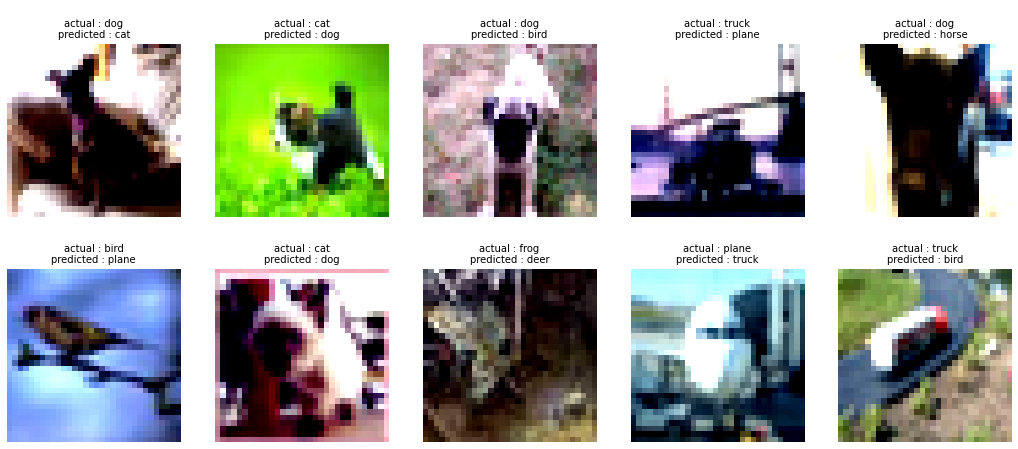

In [114]:
# model = torch.load(f'./saved_models/{experiment_name}.pt')
model.eval()
wrong_predictions(cifar_dataset.test_loader,
                  use_cuda,
                  model)

In [115]:
class_level_accuracy(model, cifar_dataset.test_loader, device)

Accuracy of airplane : 93 %
Accuracy of automobile : 100 %
Accuracy of  bird : 92 %
Accuracy of   cat : 60 %
Accuracy of  deer : 75 %
Accuracy of   dog : 62 %
Accuracy of  frog : 100 %
Accuracy of horse : 83 %
Accuracy of  ship : 90 %
Accuracy of truck : 88 %


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

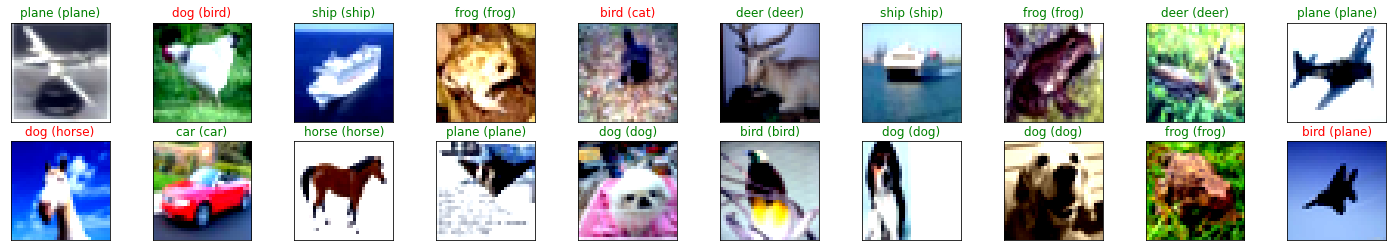

In [116]:
visualize_sample_test_result(model, 
                             cifar_dataset.test_loader,
                             use_cuda)

In [117]:
!pip install torchviz

  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4151 sha256=161620bf8b8420674b5a0bb72682887a769aea87b597269e975bbf478805892e
  Stored in directory: /root/.cache/pip/wheels/04/38/f5/dc4f85c3909051823df49901e72015d2d750bd26b086480ec2
Successfully built torchviz


In [119]:
model = model.to(device)

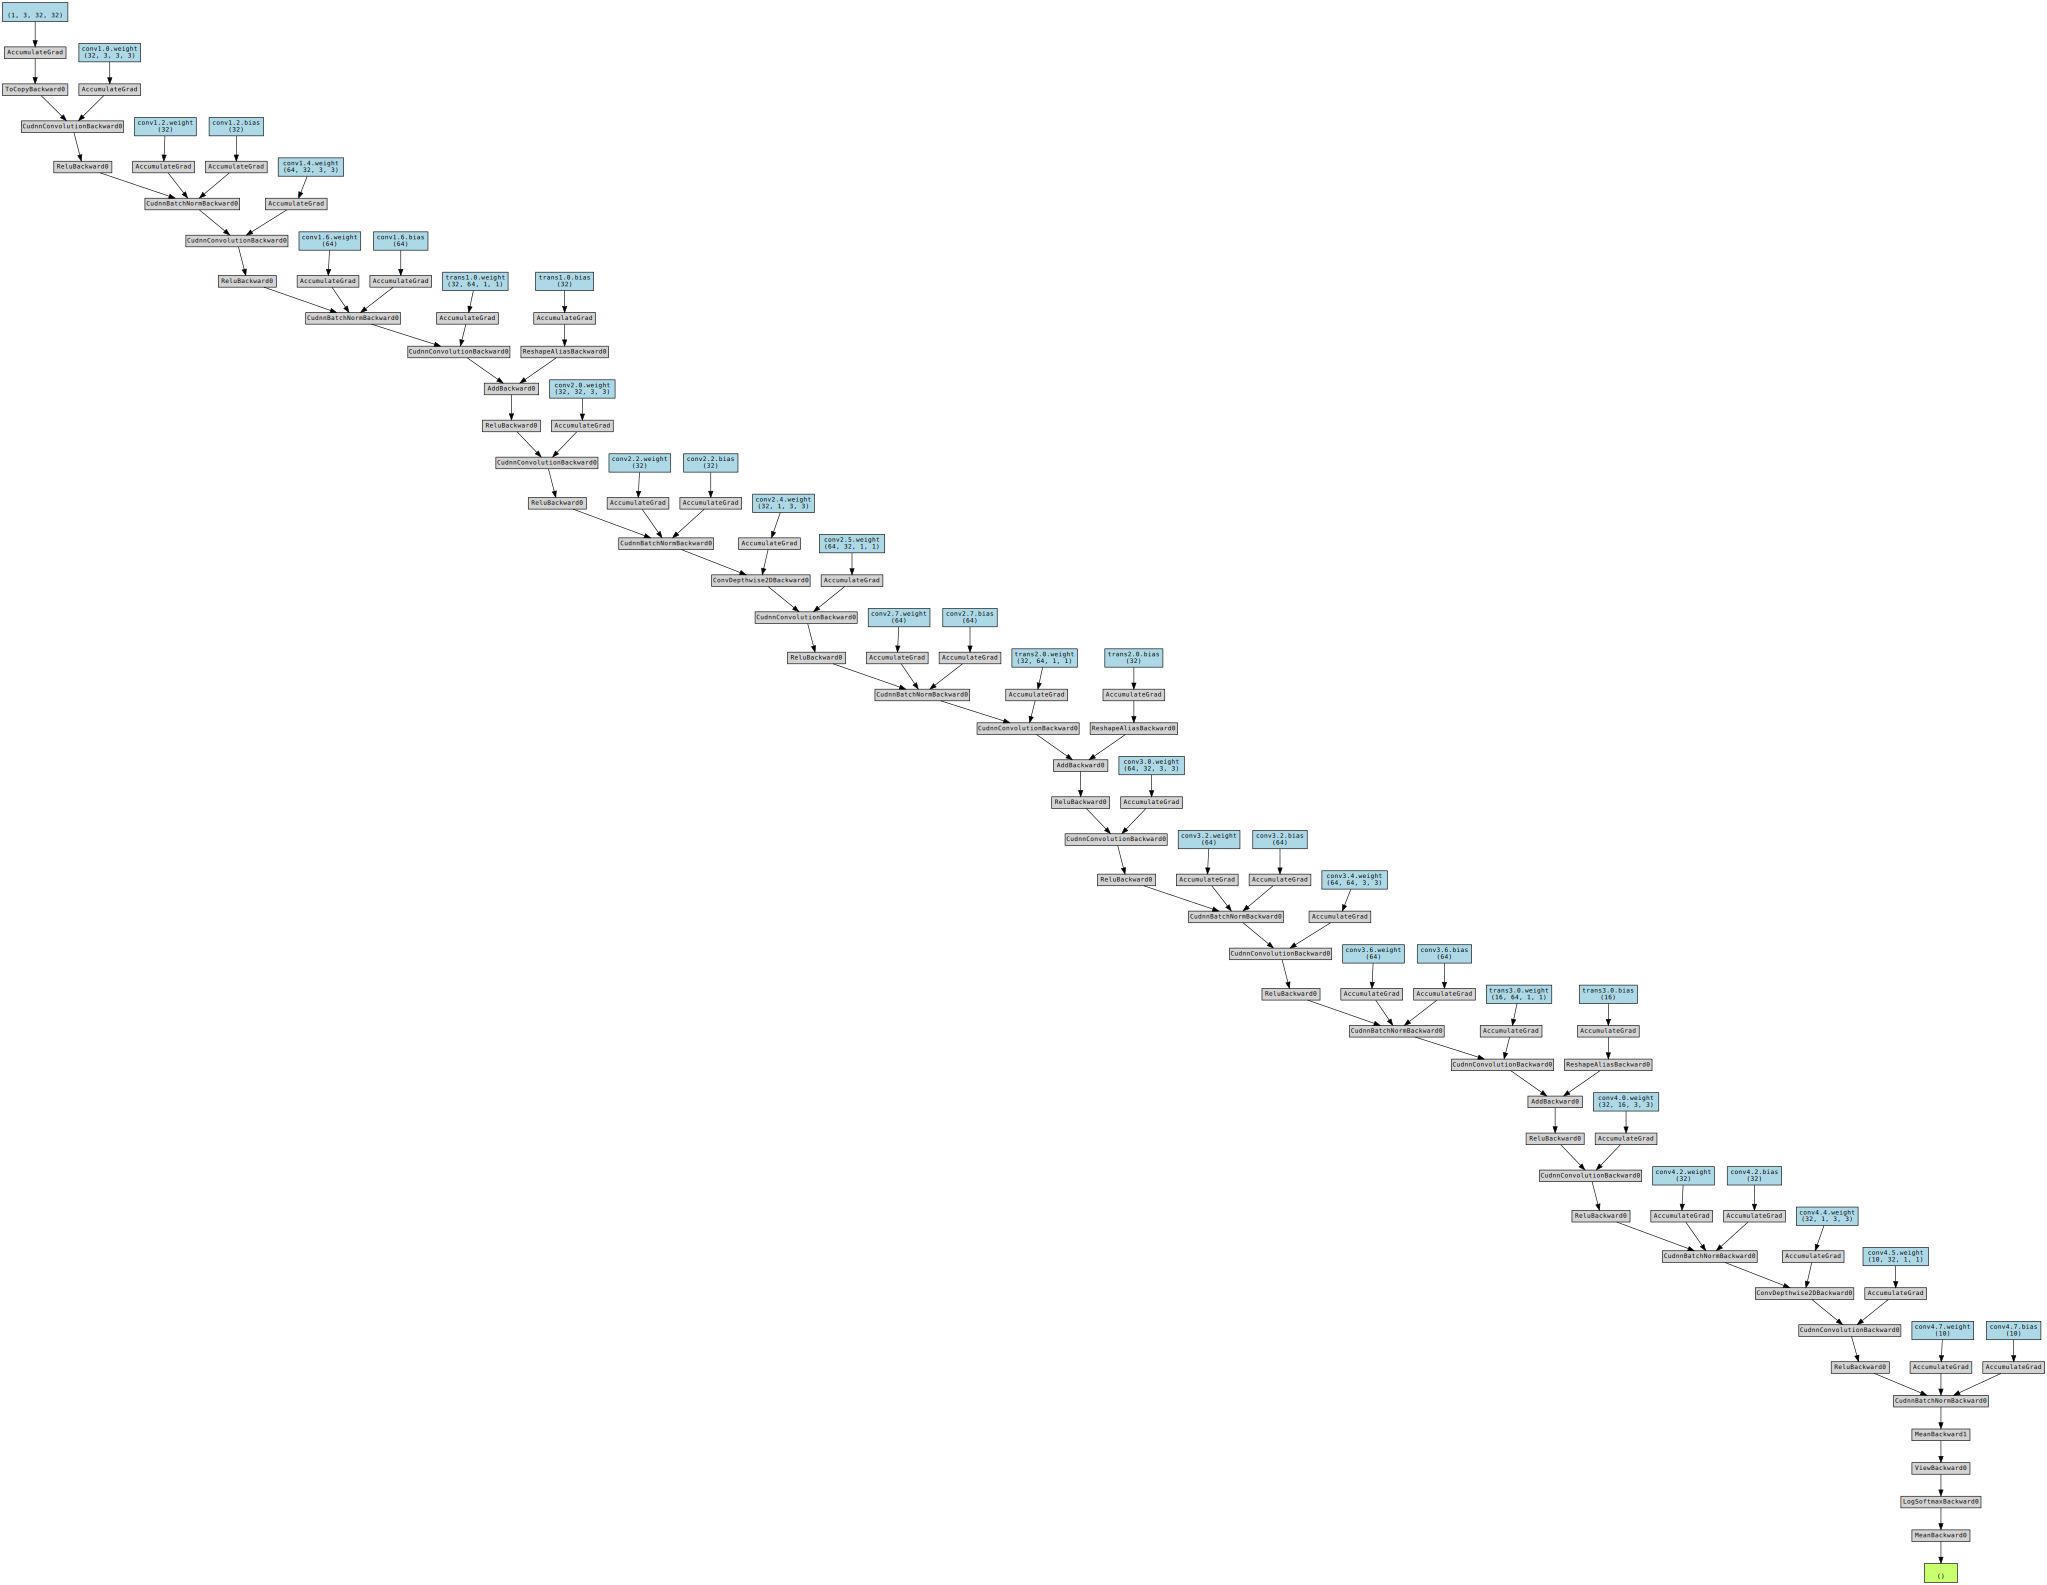

In [125]:
 from torchviz import make_dot
 x = torch.randn(1, 3, 32, 32).requires_grad_(True).cuda()
 y = model(x)   
 MyConvNetVis = make_dot(y, params=dict(list(model.named_parameters()) + [('x', x)]))
 MyConvNetVis.format = "png"
 MyConvNetVis.directory = "data"
 MyConvNetVis.view()
 make_dot(y.mean(), params=dict(model.named_parameters()))
